# Pyritz testing

### Contents

- `CollocationFF.evaluate`
    - Interpolating $f_1(t) = e^{\cos(10t)}$
- `Action.compute_action`
    - Random 1-dimensional polynomial Lagrangian
        - `CollocationFF` and `Q_clenshaw_curtis`
        - `CollocationFF` and `Q_gauss`
    - Random 2-dimensional polynomial Lagrangian
        - `CollocationFF` and `Q_clenshaw_curtis`
        - `CollocationFF` and `Q_gauss`
- `Action.compute_action_gradient`
    - `CollocationFF`

Each test can be run individually by running the corresponding cell. They can also be run using the `doctest` module, which is done in the very last cell of the notebook.

#### Setup

In [1]:
#import sys
#sys.path.insert(0, '/home/ltk26/dev/pyritz/pyritz/')

import pyritz
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
def eval_test(fval, expected_value):
    if fval == expected_value:
        print("Success")
    else:
        print("Failure")

## `CollocationFF.evaluate`

### Interpolating $f_1(t) = e^{\cos(10t)}$

#### Side-by-side plots

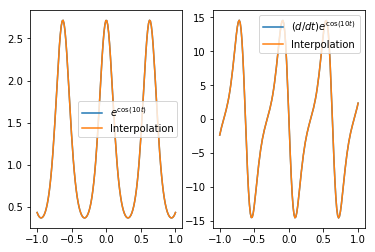

In [3]:
def func(t):
    return np.exp(np.cos(10*t))
    
def dfunc(t):
    return -10*np.exp(np.cos(10*t))*np.sin(10*t)

def diff_x(t):
    cxs, _ = ff.evaluate(m, t, dim)
    fxs = func(t)
    return np.abs(cxs-fxs)**2
    
def diff_v(t):
    _, cvs = ff.evaluate(m, t, dim)
    fvs = dfunc(t)
    return np.abs(cvs-fvs)**2

Nm = 150
dim = 1
ff = pyritz.funcfams.CollocationFF(Nm, dim)
cheb_ts = pyritz.funcfams.CollocationFF.get_chebyshev_nodes(Nm)
m = func(cheb_ts)

sample_points = 150
ts = np.linspace(-1, 1, sample_points)

cxs, cvs = ff.evaluate(m, ts)
fxs, fvs = func(ts), dfunc(ts)

fig, axs = plt.subplots(1,2)

axs[0].plot(ts, cxs)
axs[0].plot(ts, fxs)
axs[0].legend(["$e^{\cos(10t)}$", "Interpolation"])

axs[1].plot(ts, cvs)
axs[1].plot(ts, fvs)
axs[1].legend(["$(d/dt)e^{\cos(10t)}$", "Interpolation"])

#### Testing the $L^2$ distance of the interpolation

In [4]:
def test_L2_distance_of_collocation_interpolation_and_f1():
    '''
    >>> test_L2_distance_of_collocation_interpolation_and_f1()
    True
    '''
    tol = 1e-10
    
    def func(t):
        return np.exp(np.cos(10*t))

    def dfunc(t):
        return -10*np.exp(np.cos(10*t))*np.sin(10*t)

    def diff_x(t):
        cxs, _ = ff.evaluate(m, t)
        fxs = func(t)
        return np.abs(cxs-fxs)**2

    def diff_v(t):
        _, cvs = ff.evaluate(m, t)
        fvs = dfunc(t)
        return np.abs(cvs-fvs)**2

    Nm = 150
    dim = 1
    ff = pyritz.funcfams.CollocationFF(Nm, dim)
    cheb_ts = pyritz.funcfams.CollocationFF.get_chebyshev_nodes(Nm)
    m = func(cheb_ts)

    l2_distance_x = np.sqrt(integrate.quad(diff_x, -1, 1)[0])
    l2_distance_v = np.sqrt(integrate.quad(diff_v, -1, 1)[0])

    return l2_distance_x<tol and l2_distance_v<tol

eval_test(test_L2_distance_of_collocation_interpolation_and_f1(), True)

Success


## `Action.compute_action`

### Random 1-dimensional polynomial Lagrangian

Test the action evaluation of a one-dimensional Lagrangian of the form

$L(x, \dot{x}) = \sum_{i=1}^{N_L} ( a_i x^i + b_i \dot{x}^i )$

where the coefficients $\{a_i\}$ and $\{b_i\}$ are randomized, and $N_L = 5$, and the test path is a random path generated using a child class of `FunctionFamily`. The test is successful if

    np.abs(pyritz_result/quad_result) - 1 < tol

where `tol = 1e-10`, and `quad_result` result is computed using `scipy.integrate.quad`.

#### Setup

In [5]:
# Define function to avoid redundant code amongst the tests

def compute_random_one_dimensional_lagrangian(function_family, quadrature_scheme):
    lagrangian_order = 5
    lagrangian_coefficients_x = np.random.random(lagrangian_order)
    lagrangian_coefficients_v = np.random.random(lagrangian_order)
    
    def lagrangian(xs, vs, ts):

        if len(np.shape(xs)) == 1:
            xs = np.array([[xs]])
            vs = np.array([[vs]])
            ts = np.array([[ts]])

        l = np.zeros(np.size(ts))

        for i in range(np.size(xs)):
            for j in range(lagrangian_order):
                l[i] += lagrangian_coefficients_x[j] * (xs[i]**j)
                l[i] += lagrangian_coefficients_v[j] * (vs[i]**j)

        return l

    def integrand(t):
        x, v = ff.evaluate(m, t)
        return lagrangian(x, v, t)

    Nm = np.random.randint(2*lagrangian_order, 4*lagrangian_order)
    Nq = Nm*50
    dim = 1

    ff = function_family(Nm, dim)
    s = pyritz.Action(dim, ff, lagrangian, Nq, quadrature_scheme)

    m = np.random.rand(Nm)

    pyritz_result = s.compute_action(m)
    quad_result = integrate.quad(integrand, -1, 1)[0]

    return pyritz_result, quad_result

def tolerance_check(pyritz_result, quad_result):
    tol = 1e-10
    return np.abs(pyritz_result/quad_result - 1) < tol

def test_random_one_dimensional_lagrangian(function_family, quadrature_scheme):
    '''Unit tests:
    >>> test_random_one_dimensional_lagrangian(pyritz.funcfams.CollocationFF, pyritz.quads.Q_clenshaw_curtis)
    True
    >>> test_random_one_dimensional_lagrangian(pyritz.funcfams.CollocationFF, pyritz.quads.Q_gauss)
    True
    '''
    p, q = compute_random_one_dimensional_lagrangian(function_family, quadrature_scheme)
    return tolerance_check(p, q)

#### `CollocationFF` and `Q_clenshaw_curtis`

In [6]:
eval_test(test_random_one_dimensional_lagrangian(pyritz.funcfams.CollocationFF, pyritz.quads.Q_clenshaw_curtis), True)

Success


#### `CollocationFF` and `Q_gauss`

In [7]:
eval_test(test_random_one_dimensional_lagrangian(pyritz.funcfams.CollocationFF, pyritz.quads.Q_gauss), True)

Success


### Random 2-dimensional polynomial Lagrangian

Test the action evaluation of a two-dimensional Lagrangian of the form

$L(\mathbf{x}, \dot{\mathbf{x}}) = \sum_{k=1}^2 \sum_{i=1}^{N_L} ( {a^{(k)}}_i {x^{(k)}}^i + {b^{(k)}}_i {\dot{x}^{(k)}}^i )$

where the coefficients $\{{a^{(k)}}_i\}$ and $\{{b^{(k)}}_i\}$ are randomized, and $N_L = 5$, and the test path is a random path generated using a child class of `FunctionFamily`. The test is successful if

    np.abs(pyritz_result/quad_result) - 1 < tol

where `tol = 1e-10`, and `quad_result` result is computed using `scipy.integrate.quad`.

In [8]:
# Define functions used for the test

def compute_random_two_dimensional_lagrangian(function_family, quadrature_scheme):
    lagrangian_order = 5
    lagrangian_coefficients_x1 = np.random.random(lagrangian_order)
    lagrangian_coefficients_x2 = np.random.random(lagrangian_order)
    lagrangian_coefficients_v1 = np.random.random(lagrangian_order)
    lagrangian_coefficients_v2 = np.random.random(lagrangian_order)

    def lagrangian(xs, vs, ts):
        if len(np.shape(xs)) == 1:
            xs = np.array([xs])
            vs = np.array([vs])
            ts = np.array([ts])

        l = np.zeros(np.size(ts))

        for i in range(np.shape(xs)[0]):
            for j in range(lagrangian_order):
                l[i] += lagrangian_coefficients_x1[j] * (xs[i][0]**j) + lagrangian_coefficients_x2[j] * (xs[i][1]**j)
                l[i] += lagrangian_coefficients_v1[j] * (vs[i][0]**j) + lagrangian_coefficients_v2[j] * (vs[i][1]**j)

        return l

    def integrand(t):
        x, v = ff.evaluate(m, t)
        return lagrangian(x, v, t)

    Nm = np.random.randint(2*lagrangian_order, 4*lagrangian_order)
    Nq = Nm*50
    dim = 2

    ff = function_family(Nm, dim)
    s = pyritz.Action(dim, ff, lagrangian, Nq, quadrature_scheme)

    m = np.random.rand(dim*Nm)

    pyritz_result = s.compute_action(m)
    quad_result = integrate.quad(integrand, -1, 1)[0]
    
    return pyritz_result, quad_result

def tolerance_check(pyritz_result, quad_result):
    tol = 1e-10
    return np.abs(pyritz_result/quad_result - 1) < tol

def test_random_two_dimensional_lagrangian(function_family, quadrature_scheme):
    '''Unit tests:
    >>> test_random_two_dimensional_lagrangian(pyritz.funcfams.CollocationFF, pyritz.quads.Q_clenshaw_curtis)
    True
    >>> test_random_two_dimensional_lagrangian(pyritz.funcfams.CollocationFF, pyritz.quads.Q_gauss)
    True
    '''
    p, q = compute_random_two_dimensional_lagrangian(function_family, quadrature_scheme)
    return tolerance_check(p, q)

#### `CollocationFF` and `Q_clenshaw_curtis`

In [9]:
eval_test(test_random_two_dimensional_lagrangian(pyritz.funcfams.CollocationFF, pyritz.quads.Q_clenshaw_curtis), True)

Success


#### `CollocationFF` and `Q_gauss`

In [10]:
eval_test(test_random_two_dimensional_lagrangian(pyritz.funcfams.CollocationFF, pyritz.quads.Q_gauss), True)

Success


## `Action.compute_action_gradient`

Test the Pyritz gradient computation. The Lagrangian used is

$L(\mathbf{x}, \dot{\mathbf{x}}) = \frac{1}{2} | \dot{\mathbf{x}} - \mathbf{a}(\mathbf{x}) |^2$

where

$\mathbf{a}(x, y) = \left\{ 10 x^2 - \frac{1}{20} \cos x \exp y, (y - x)^3 + \cos(x-y) \right\}.$

The result of `Action.compute_action_gradient` is compared with a finite difference derivative. The test is successful if

    np.linalg.norm(dS - dS_finite_difference) < tol

where `tol = 1e-5`.

In [11]:
def test_gradient(function_family, quadrature_scheme, tol=1e-5):
    '''Unit tests:
    >>> test_gradient(pyritz.funcfams.CollocationFF, pyritz.quads.Q_gauss)
    True
    '''

    def lagrangian(xs, vs, ts):
        if len(xs.shape) == 1:
            xs = np.array([xs])
            vs = np.array([vs])
        x = xs[:,0]
        y = xs[:,1]
        vx = vs[:,0]
        vy = vs[:,1]
        return ((vx - 10*x**2 + (np.exp(y)*np.cos(x))/20.)**2 + (vy + (x - y)**3 - np.cos(x - y))**2)/2.

    def dxlagrangian(xs, vs, ts):
        x = xs[:,0]
        y = xs[:,1]
        vx = vs[:,0]
        vy = vs[:,1]
        dxl = np.array([
            (vx - 10*x**2 + (np.exp(y)*np.cos(x))/20.)*(-20*x - (np.exp(y)*np.sin(x))/20.) + (vy + (x - y)**3 - np.cos(x - y))*(3*(x - y)**2 + np.sin(x - y)),
            (np.exp(y)*np.cos(x)*(vx - 10*x**2 + (np.exp(y)*np.cos(x))/20.))/20. + (vy + (x - y)**3 - np.cos(x - y))*(-3*(x - y)**2 - np.sin(x - y))
        ]).T
        return dxl

    def dvlagrangian(xs, vs, ts):
        x = xs[:,0]
        y = xs[:,1]
        vx = vs[:,0]
        vy = vs[:,1]
        dvl = np.array([
            vx - 10*x**2 + (np.exp(y)*np.cos(x))/20.,
            vy + (x - y)**3 - np.cos(x - y)
        ]).T
        return dvl

    Nm = 10
    Nq = Nm*10
    dim = 2

    ff = function_family(Nm, dim)
    s = pyritz.Action(dim, ff, lagrangian, Nq, quadrature_scheme, dxlagrangian, dvlagrangian)

    m = np.random.rand(dim*Nm)

    dS_finite_difference = np.zeros(dim*Nm)
    for i in range(dim*Nm):
        dm = np.zeros( dim*Nm )
        dd = 1e-8
        dm[i] = dd
        dS_finite_difference[i] = (s.compute_action(m + dm) - s.compute_action(m-dm))/(2*dd)

    dS = s.compute_action_gradient(m)

    return np.linalg.norm(dS_finite_difference - dS) < tol

#### `CollocationFF`

In [12]:
eval_test(test_gradient(pyritz.funcfams.CollocationFF, pyritz.quads.Q_gauss), True)

Success


## Doctest

In [13]:
import doctest
doctest.testmod(verbose=False)

TestResults(failed=0, attempted=6)